<a href="https://colab.research.google.com/github/Kelompok3Alpro/LAPORAN-ALPRO/blob/main/ResNet_50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten, Dropout
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomBrightness, RandomZoom, Rescaling
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [ ]:
training_ds = image_dataset_from_directory('/content/drive/MyDrive/GuavaDiseaseDataset/train',
                                  label_mode = "categorical",
                                  image_size=(224,224), interpolation="nearest",
                                  crop_to_aspect_ratio=True,
                                  seed=42, shuffle=True, batch_size=32)
validation_ds = image_dataset_from_directory('/content/drive/MyDrive/GuavaDiseaseDataset/val',
                                  label_mode = "categorical",
                                  image_size=(224,224), interpolation="nearest",
                                  crop_to_aspect_ratio=True,
                                  seed=42, shuffle=True, batch_size=32)
test_ds = image_dataset_from_directory('/content/drive/MyDrive/GuavaDiseaseDataset/test',
                                  label_mode = "categorical",
                                  image_size=(224,224), interpolation="nearest",
                                  crop_to_aspect_ratio=True,
                                  seed=42, shuffle=True, batch_size=32)

Found 1800 files belonging to 3 classes.
Found 900 files belonging to 3 classes.
Found 300 files belonging to 3 classes.


In [ ]:
# getting the detected labels
training_ds.class_names

['Anthracnose', 'fruit_fly', 'healthy_guava']

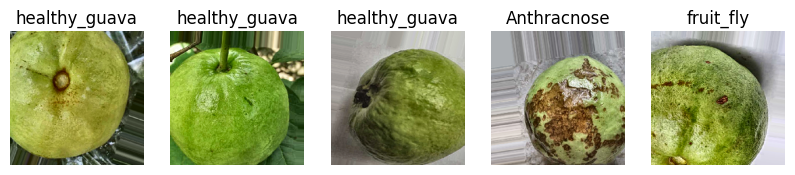

In [ ]:
# plotting the first five images
plt.figure(figsize=(10, 10))
for images, labels in training_ds.take(1):
    for i in range(5):
        plt.subplot(1, 5, i+1)
        index = np.where(labels[i].numpy()  == 1)[0][0]
        plt.title(training_ds.class_names[index])
        plt.imshow(images[i])
        plt.axis('off')
plt.show()

In [ ]:
for image_batch, labels_batch in training_ds:
  print("Image batch shape:", image_batch.shape)
  print("Label batch shape:", labels_batch.shape)
  break

Image batch shape: (32, 224, 224, 3)
Label batch shape: (32, 3)


In [ ]:
# loading base model with pretrained weights, excluding the top layers
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# unfreezing some layers to allow fine-tuning
base_model.trainable = True
for layer in base_model.layers[:-20]:
    layer.trainable = False

# adjusting the learning rate for fine-tuning
fine_tune_learning_rate = 1e-5

In [ ]:
data_augmentation = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.2),
    RandomZoom(0.3),
    RandomBrightness(0.3),
])

augmented_ds = training_ds.map(lambda x, y: (data_augmentation(x), y))

In [ ]:
# model to be trained
model = Sequential([
    Rescaling(1./255),
    base_model,
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(training_ds.class_names), activation='softmax')
])

In [ ]:
# compiling the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

In [ ]:
# training the model
history_base = model.fit(training_ds, validation_data=validation_ds, epochs=100, batch_size=32, callbacks=[early_stopping])

Epoch 1/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 44s 575ms/step - accuracy: 0.7910 - loss: 1.6758 - val_accuracy: 0.7000 - val_loss: 19.5949
Epoch 2/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 21s 373ms/step - accuracy: 0.9202 - loss: 0.4342 - val_accuracy: 0.6122 - val_loss: 7.0620
Epoch 3/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 42s 389ms/step - accuracy: 0.9619 - loss: 0.1504 - val_accuracy: 0.8978 - val_loss: 0.9863
Epoch 4/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 41s 396ms/step - accuracy: 0.9718 - loss: 0.1350 - val_accuracy: 0.9322 - val_loss: 0.4423
Epoch 5/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 25s 437ms/step - accuracy: 0.9809 - loss: 0.0543 - val_accuracy: 0.9244 - val_loss: 0.4893
Epoch 6/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 21s 370ms/step - accuracy: 0.9689 - loss: 0.1262 - val_accuracy: 0.7744 - val_loss: 10.9395
Epoch 7/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 23s 395ms/step - accuracy: 0.9760 - loss: 0.1090 - val_accuracy: 0.9122 - val_loss: 1.8504
Epoch 8/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 41s 387ms/step - accuracy: 0.9811 - loss: 0.0766 

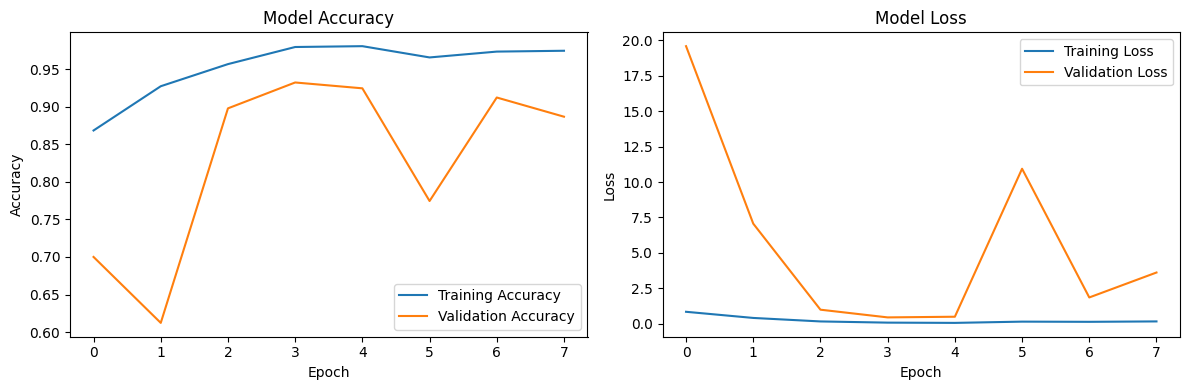

In [ ]:
history_total = {}
history_total['accuracy'] = history_base.history['accuracy']
history_total['val_accuracy'] = history_base.history['val_accuracy']
history_total['loss'] = history_base.history['loss']
history_total['val_loss'] = history_base.history['val_loss']

# Plot training curves
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_total['accuracy'], label='Training Accuracy')
plt.plot(history_total['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_total['loss'], label='Training Loss')
plt.plot(history_total['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Getting test accuracy
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test accuracy: {test_accuracy:.4f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9301 - loss: 0.3503
Test accuracy: 0.9200


In [ ]:
aux_ds = test_ds.cache() # cached dataset; it won't reshuffle every time it's called
predictions = model.predict(aux_ds)

10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 461ms/step


In [ ]:
# converting preds to a list of numeric values
preds = np.round(predictions)
preds = np.array([np.where(a == np.max(a))[0][0] for a in preds])

In [ ]:
# converting actual labels to a list of numeric values
actual = np.array([label.numpy() for _, label in aux_ds.unbatch()])
actual = np.array([np.where(a == np.max(a))[0][0] for a in actual])

In [ ]:
# Getting the metrics
print(classification_report(actual, preds))

              precision    recall  f1-score   support

           0       0.98      0.93      0.95       100
           1       0.89      0.94      0.91       100
           2       0.90      0.89      0.89       100

    accuracy                           0.92       300
   macro avg       0.92      0.92      0.92       300
weighted avg       0.92      0.92      0.92       300



<Figure size 600x500 with 0 Axes>

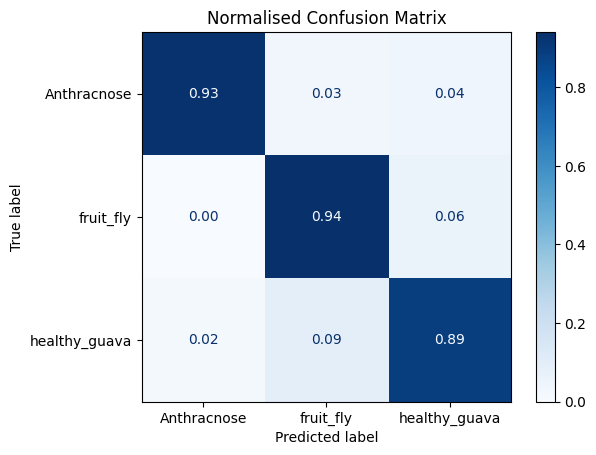

<Figure size 600x500 with 0 Axes>

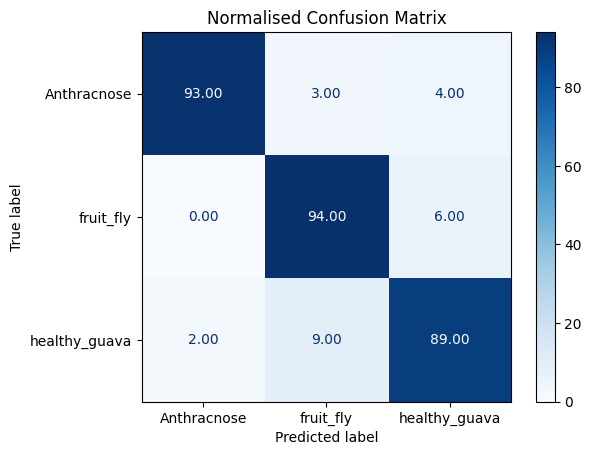

In [ ]:
# Displaying confusion matrices
cm_normalised = confusion_matrix(actual, preds, normalize='true')
disp_normalised = ConfusionMatrixDisplay(confusion_matrix=cm_normalised, display_labels=training_ds.class_names)
plt.figure(figsize=(6,5))
disp_normalised.plot(cmap='Blues', values_format='.2f')
plt.title('Normalised Confusion Matrix')
plt.show()

cm = confusion_matrix(actual, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=training_ds.class_names)
plt.figure(figsize=(6,5))
disp.plot(cmap='Blues', values_format='.2f')
plt.title('Normalised Confusion Matrix')
plt.show()

In [ ]:
model.save('guava_disease_detection_model.h5')

In [ ]:
# prompt: convert ke tflite

# Convert the Keras model to a TensorFlow Lite model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TensorFlow Lite model.
with open('guava_disease_detection_model.tflite', 'wb') as f:
  f.write(tflite_model)

print("Model converted to TFLite and saved as 'guava_disease_detection_model.tflite'")


Saved artifact at '/tmp/tmp5j84pm2y'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_195')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  132442700154448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132442700156944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132442700157328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132442700154640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132442700155024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132442700157136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132442700159248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132442700160976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132442700160016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132442700160784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1324427001